In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf_config=tf.ConfigProto()
tf_config.gpu_options.allow_growth=True
sess = tf.Session(config=tf_config)

### Load CIFAR 10

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

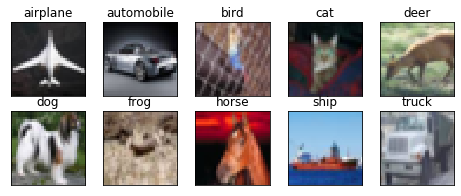

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [5]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [6]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [7]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
train_mean = np.mean(train_features, axis=(0,1,2))
train_std = np.std(train_features, axis=(0,1,2))

train_mean, train_std

(array([0.4914009 , 0.48215896, 0.4465308 ], dtype=float32),
 array([0.24703279, 0.24348423, 0.26158753], dtype=float32))

### Image Preprocessing
- Add padding of 4px
- Random crop of 32
- horizontal flip with p=0.5

In [9]:
import random, cv2
def random_cut(im_numpy,coutout_shape):
    shape=im_numpy.shape[0]
    x = random.randint(0,shape-coutout_shape)
    y = random.randint(0,shape-coutout_shape)
    im_numpy = im_numpy[x:x+coutout_shape,y:y+coutout_shape]
    return(im_numpy)
    
    

In [10]:

def img_preprocess(im_numpy):
    im_numpy = np.pad(im_numpy,[(4, 4), (4, 4),(0, 0)],mode='edge')
    rand_no = random.randint(0,9)
    if rand_no>4:
        flip_img = cv2.flip(im_numpy, 1)
        return(random_cut(flip_img,32))
    else:
        return(random_cut(im_numpy,32))

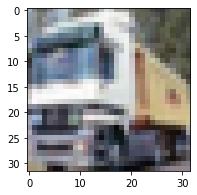

In [11]:
fig = plt.figure(figsize=(8,3))
plt.imshow(train_features[1])

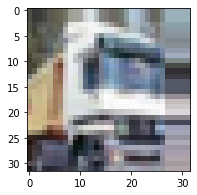

In [12]:
fig = plt.figure(figsize=(8,3))
plt.imshow(img_preprocess(train_features[1]))

### Run the pre-processing on training images

In [13]:
for i,j in enumerate(train_features):
    train_features[i]=img_preprocess(j)

    

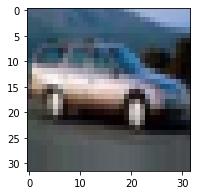

In [14]:
fig = plt.figure(figsize=(8,3))
plt.imshow(train_features[4])

### Normalize the images with given mean and std

In [15]:
train_mean = [0.4914,0.4822,0.4465]
train_std = [0.2023, 0.1994, 0.2010]

In [16]:
normalize = lambda x: ((x - train_mean) / train_std).astype('float32')

In [17]:
train_features = normalize(train_features)
test_features = normalize(test_features)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


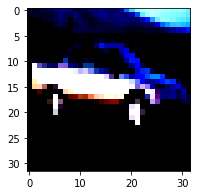

In [18]:
fig = plt.figure(figsize=(8,3))
plt.imshow(train_features[4])

### Define a model

In [19]:
class Conv_block(tf.keras.Model):
    def __int__(self, c_out,drop=False):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out,kernel_size=3,padding='same')
        self.bn_layer = tf.keras.layers.BatchNormalization()
        if drop:
            self.drop = tf.keras.layers.Dropout(0.05)
            
    def call(self,inputs):
        if drop:
            return(tf.nn.relu(self.bn_layer(self.drop(self.conv(inputs))))) 
        return(tf.nn.relu(self.bn_layer(self.conv(inputs))))

In [20]:
class Resnet_block(tf.keras.Model):
    def __init__(c_out,pool,res):
        super().__int__()
        self.conv_layer_1 = Conv_block(c_out)
        self.conv_layer_2 = Conv_block(c_out)
        self.conv_layer_3 = Conv_block(c_out)
        self.conv_layer_4 = Conv_block(c_out)        
        
        if pool:
            self.pool = pool
#         if res:
#             self.res1 = 
    def call(self,pool,inputs):
        h1 = self.conv_layer_2(self.conv_layer_1(inputs))
        h2 = h1 + inputs
        h3 = self.conv_layer_4(self.conv_layer_3(h2))
        return(h3)
        

In [21]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Add, Concatenate,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [22]:
def conv_block(inputs, c_out,kernel_size=3,pool=None,padding='same',strides=1,dropout=False):
    X = Convolution2D(filters=c_out,kernel_size=kernel_size,strides=strides,padding=padding)(inputs)
    if pool:
        X = pool()(X)
    if dropout:
        X=Dropout(0.05)(X)
    return(Activation('relu')(X))

In [23]:
def resnet_block(inputs,c_out,pool=None,strides=False):
    if strides:
        X = conv_block(inputs, c_out,kernel_size=3,pool=pool,strides=2)
    else:
        X = conv_block(inputs, c_out,kernel_size=3,pool=pool)
    if inputs.get_shape()[1:]==X.get_shape()[1:]:
        print('equal')
        h = Add()([inputs,X])
    else:
        print(inputs.get_shape())
        print(X.get_shape())
        inputs = Convolution2D(filters=c_out,kernel_size=(1,1),padding='valid',strides=2)(inputs)
        print(inputs.get_shape())
        h = Add()([inputs,X])
    X2 = conv_block(h, c_out,kernel_size=3,pool=pool,padding='same')
    X3 = conv_block(X2, c_out,kernel_size=3,pool=pool,padding='same')
    if h.get_shape()[1:]== X3.get_shape()[1:]:
        print('equal')
        X_final = Add()([X3,h])
    else:
        print('inside second part')
        print(h.get_shape())
        print(X3.get_shape())
        h = Convolution2D(filters=c_out,kernel_size=(1,1),strides=2,padding='same')(inputs)
        print(h.get_shape())
        X_final = Add()([X3,h])
    
    return(X_final)

In [36]:
input_layer = Input(shape=(32,32,3))
X =  conv_block(input_layer, c_out=64,kernel_size=3,pool=None,strides=1,padding='valid')
X1 =  conv_block(X, c_out=64,kernel_size=3,pool=None,strides=1,padding='valid')
X2 = resnet_block(X1,c_out=64,pool=None,strides=False)
X3 = resnet_block(X2,c_out=128,pool=None,strides=True)
X4 = resnet_block(X3,c_out=256,pool=None,strides=True)
X5 = resnet_block(X4,c_out=512,pool=None,strides=True)
X6 = conv_block(X5,c_out=10,kernel_size=1,pool=None,strides=1,padding='valid')
# X7 = conv_block(X5,c_out=10,kernel_size=4,pool=None,strides=1,padding='valid')
# flatten_output = Flatten()(X7)
final_layer = GlobalAveragePooling2D()(X6)
# X4 = resnet_block(X3,c_out=256,pool=None,strides=False)

equal
equal
(?, 28, 28, 64)
(?, 14, 14, 128)
(?, 14, 14, 128)
equal
(?, 14, 14, 128)
(?, 7, 7, 256)
(?, 7, 7, 256)
equal
(?, 7, 7, 256)
(?, 4, 4, 512)
(?, 4, 4, 512)
equal


In [38]:
model = Model(inputs=input_layer, outputs=final_layer)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 30, 30, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 30, 30, 64)   0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 28, 28, 64)   36928       activation_48[0][0]              
____________________________________________________________________________________________

In [41]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-5)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/home/anuda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/home/anuda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
 39/390 [==>...........................] - ETA: 19s - loss: 3.6746 - accuracy: 0.1224

In [ ]:
# plot_model_history(model_info)

In [ ]:
# print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [ ]:
# # inputs = Convolution2D(c_out=32,pool=MaxPooling2D)
# input_layer = Input(shape=(32,32,3))
# X =  conv_block(input_layer, c_out=32,pool=MaxPooling2D)
# X1 = resnet_block(X,c_out=32,pool=None)
# X2 = resnet_block(X1,c_out=64,pool=None)
# X3 = resnet_block(X2,c_out=128,pool=None)
# X4 = resnet_block(X3,c_out=128,pool=None)

In [ ]:
# model = Model(inputs=input_layer, outputs=X4)
# model.summary()